# Summary notebook for the SLCP problem

In [1]:
import hypothesis as h
import numpy as np
import torch
import glob
import os
import matplotlib.pyplot as plt

from ratio_estimation import load_estimator
from ratio_estimation import DatasetJointTest
from plotting import plot_posterior
from plotting import plot_contours
from pipeline import simulations
from util import simulate

In [2]:
h.plot.activate()

## Setting

Notebook arguments. The following cell also contains the `parameters` tag, such that it can be parameterized with [Papermill](https://papermill.readthedocs.io/en/latest/).

In [3]:
root = os.path.abspath('')
datadir = root + "/data"
outputdir = root + "/output"

In [4]:
# Prepare the plotting directory
plotdir = outputdir + "/plots"
!rm -r $plotdir
!mkdir -p $plotdir

rm: cannot remove '/home/joeri/Workspace/casbi/workflows/coverage-simulations-and-bias-reduction/slcp/output/plots': No such file or directory


## Utilities

In [5]:
def load_coverage(budget, classifier=False, flow=False, calibrated=True):
    assert classifier or flow
    query = "output/{budget}".format(budget=budget)
    if calibrated:
        query += "/with-calibration"
    else:
        query += "/without-calibration"
    if classifier:
        query += "/mlp-0*/coverage.npy"
    if flow:
        query = "/flow-0*/coverage.npy"
    paths = glob.glob(query)
    coverages = [np.load(p) for p in paths]
    
    return np.mean(coverages), np.std(coverages)

In [6]:
@torch.no_grad()
def estimate_mi(r, n=10000):
    d = DatasetJointTest()
    indices = np.random.choice(np.arange(len(d)), n, replace=False)
    inputs = d[indices]["inputs"]
    outputs = d[indices]["outputs"]
    log_ratios = r.log_ratio(inputs=inputs, outputs=outputs)
    
    return log_ratios.mean()

In [7]:
@torch.no_grad()
def estimate_calibration(r, n=50000):
    d = DatasetJointTest()
    indices = np.random.choice(np.arange(len(d)), n, replace=False)
    inputs = d[indices]["inputs"]
    outputs = d[indices]["outputs"]
    # Joint
    d_joint, _ = r(inputs=inputs, outputs=outputs)
    # Marginals
    indices = np.random.choice(n, n, replace=False)
    inputs = inputs[indices]
    d_marginals, _ = r(inputs=inputs, outputs=outputs)
    
    return (d_joint.mean() + d_marginals.mean()).item()

## Coverages

### With calibration

2021-04-09 15:10:10 orion matplotlib.font_manager[31310] WARNING findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


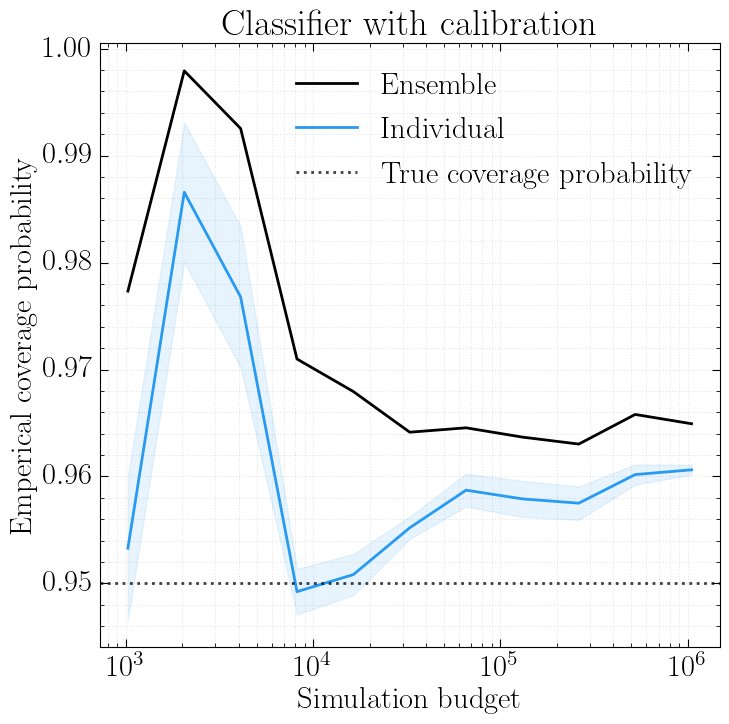

In [8]:
coverages_ensemble = [np.load("output/{budget}/with-calibration/coverage-classifier.npy".format(budget=s)) for s in simulations]
m = np.asarray([load_coverage(s, classifier=True)[0] for s in simulations])
s = np.asarray([load_coverage(s, classifier=True)[1] for s in simulations])
plt.plot(simulations, coverages_ensemble, label="Ensemble")
plt.plot(simulations, m, label="Individual")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")
plt.xscale("log")
plt.xlabel("Simulation budget")
plt.ylabel("Emperical coverage probability")
plt.title(r"Classifier with calibration")
plt.axhline(0.95, linestyle=':', alpha=.75, label="True coverage probability")
plt.legend()
plt.show()

/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


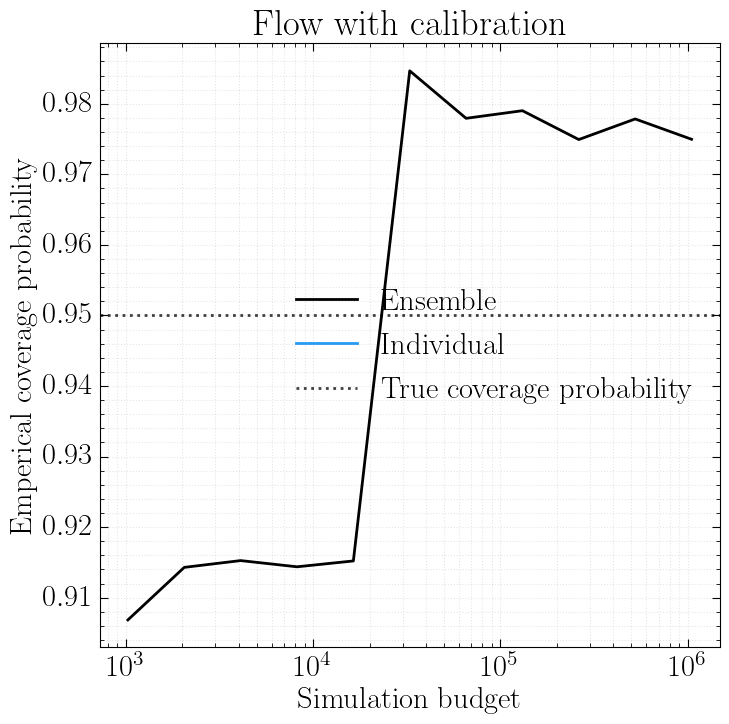

In [9]:
coverages_ensemble = [np.load("output/{budget}/with-calibration/coverage-flow.npy".format(budget=s)) for s in simulations]
m = np.asarray([load_coverage(s, flow=True)[0] for s in simulations])
s = np.asarray([load_coverage(s, flow=True)[1] for s in simulations])
plt.plot(simulations, coverages_ensemble, label="Ensemble")
plt.plot(simulations, m, label="Individual")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")
plt.xscale("log")
plt.xlabel("Simulation budget")
plt.ylabel("Emperical coverage probability")
plt.title(r"Flow with calibration")
plt.axhline(0.95, linestyle=':', alpha=.75, label="True coverage probability")
plt.legend()
plt.show()

### Without calibration

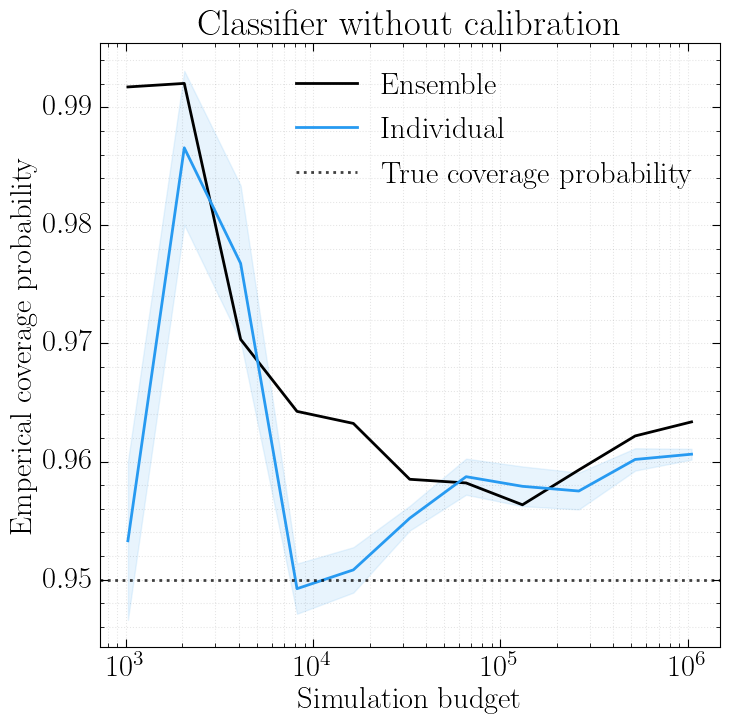

In [10]:
coverages_ensemble = [np.load("output/{budget}/without-calibration/coverage-classifier.npy".format(budget=s)) for s in simulations]
m = np.asarray([load_coverage(s, classifier=True)[0] for s in simulations])
s = np.asarray([load_coverage(s, classifier=True)[1] for s in simulations])
plt.plot(simulations, coverages_ensemble, label="Ensemble")
plt.plot(simulations, m, label="Individual")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")
plt.xscale("log")
plt.xlabel("Simulation budget")
plt.ylabel("Emperical coverage probability")
plt.title(r"Classifier without calibration")
plt.axhline(0.95, linestyle=':', alpha=.75, label="True coverage probability")
plt.legend()
plt.show()

/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/joeri/Anaconda/envs/casbi/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


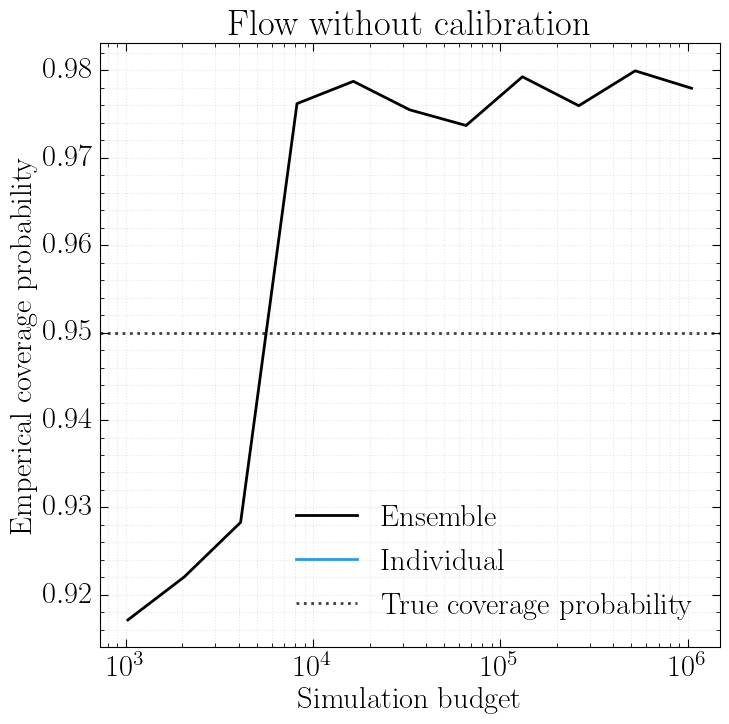

In [11]:
coverages_ensemble = [np.load("output/{budget}/without-calibration/coverage-flow.npy".format(budget=s)) for s in simulations]
m = np.asarray([load_coverage(s, flow=True)[0] for s in simulations])
s = np.asarray([load_coverage(s, flow=True)[1] for s in simulations])
plt.plot(simulations, coverages_ensemble, label="Ensemble")
plt.plot(simulations, m, label="Individual")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")
plt.xscale("log")
plt.xlabel("Simulation budget")
plt.ylabel("Emperical coverage probability")
plt.title(r"Flow without calibration")
plt.axhline(0.95, linestyle=':', alpha=.75, label="True coverage probability")
plt.legend()
plt.show()

## Calibration

### With calibration

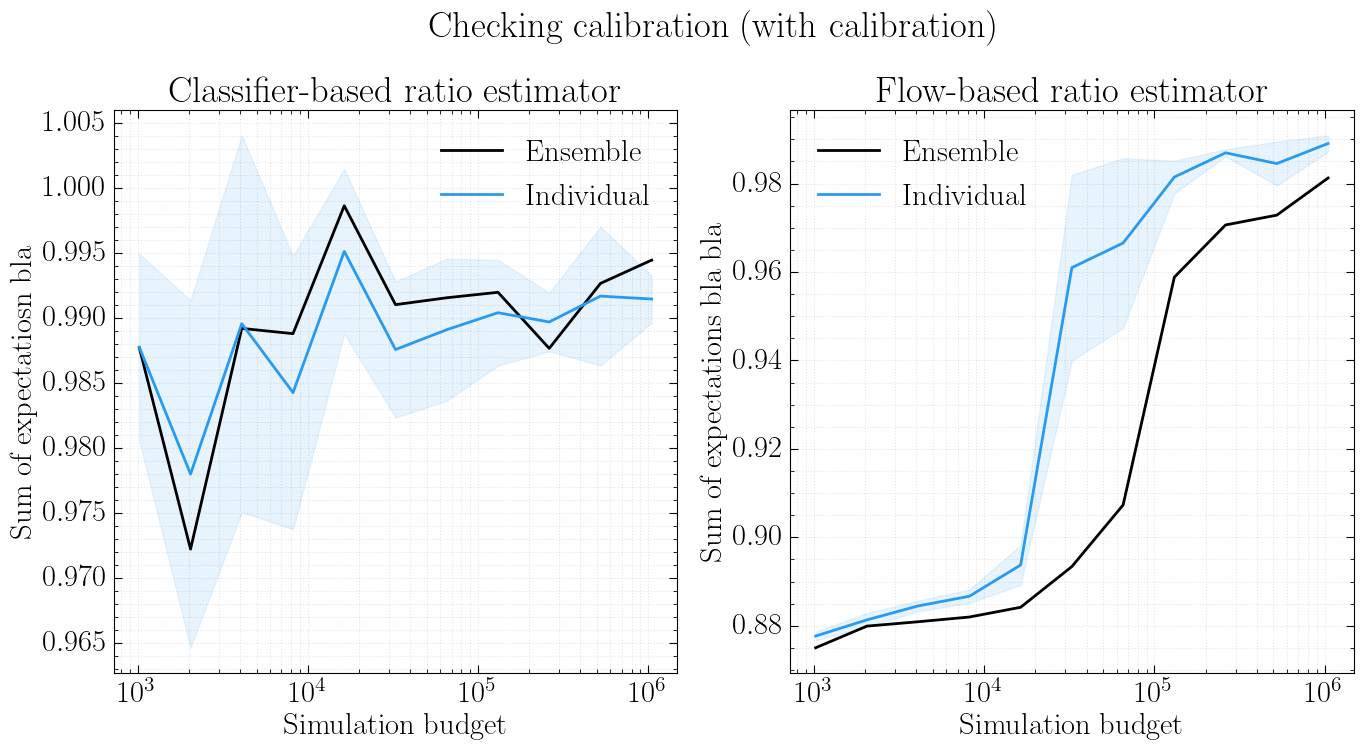

In [12]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
f.suptitle("Checking calibration (with calibration)")

# Classifier
ax = axes[0]

## Ensemble
calibrations = []
for b in simulations:
    query = "output/{budget}/with-calibration/mlp-*/weights.th".format(budget=b)
    r = load_estimator(query)
    calibrations.append(estimate_calibration(r))
ax.plot(simulations, calibrations, label="Ensemble")

## Individual model
calibrations = []
for b in simulations:
    query = "output/{budget}/with-calibration/mlp-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_calibration(r))
    calibrations.append(estimates)
calibrations = np.asarray(calibrations)
m = np.mean(calibrations, axis=1)
s = np.std(calibrations, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Classifier-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Sum of expectatiosn bla")
ax.set_xlabel("Simulation budget")
ax.legend()
h.plot.make_square(ax)

# Flow
ax = axes[1]

## Ensemble
calibrations = []
for b in simulations:
    query = "output/{budget}/with-calibration/flow-*/weights.th".format(budget=b)
    r = load_estimator(query)
    calibrations.append(estimate_calibration(r))
ax.plot(simulations, calibrations, label="Ensemble")

## Individual model
calibrations = []
for b in simulations:
    query = "output/{budget}/with-calibration/flow-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_calibration(r))
    calibrations.append(estimates)
calibrations = np.asarray(calibrations)
m = np.mean(calibrations, axis=1)
s = np.std(calibrations, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Flow-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Sum of expectations bla bla")
ax.set_xlabel("Simulation budget")
ax.legend()
h.plot.make_square(ax)

plt.show()

### Without calibration

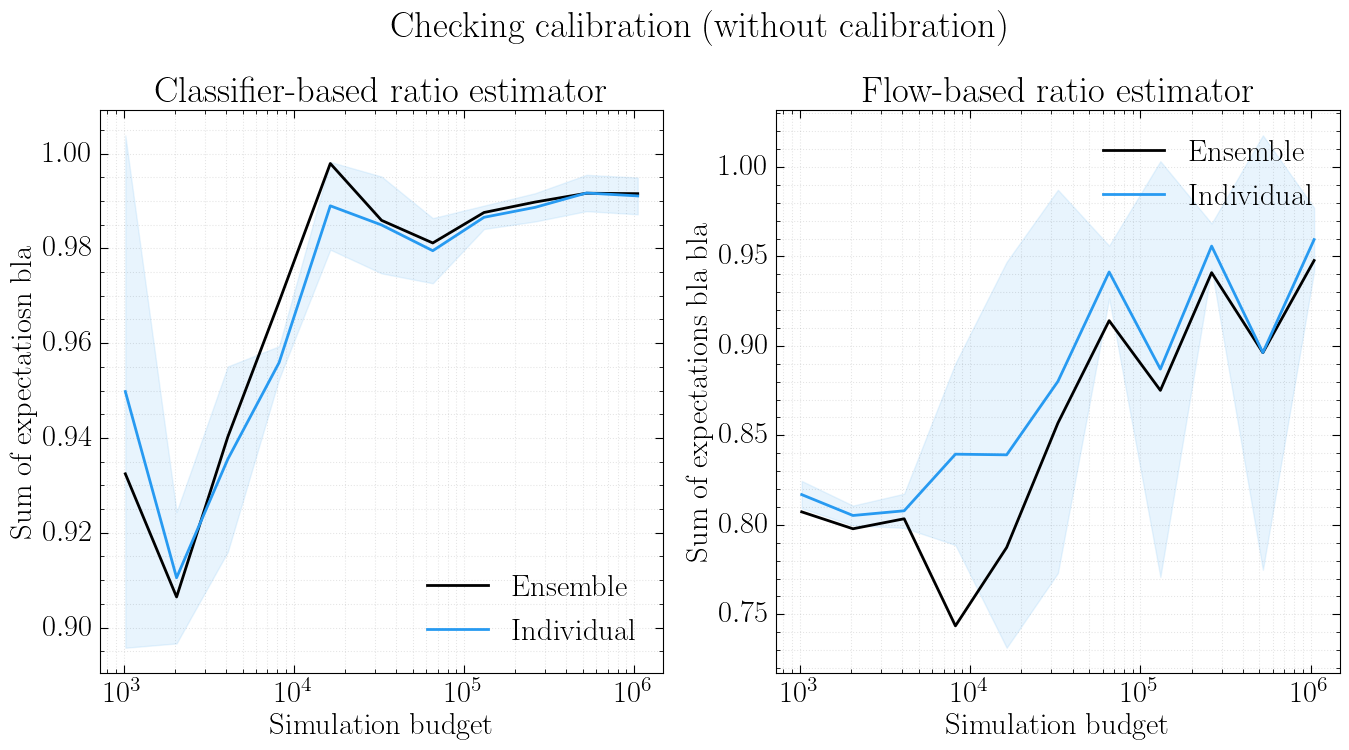

In [13]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
f.suptitle("Checking calibration (without calibration)")

# Classifier
ax = axes[0]

## Ensemble
calibrations = []
for b in simulations:
    query = "output/{budget}/without-calibration/mlp-*/weights.th".format(budget=b)
    r = load_estimator(query)
    calibrations.append(estimate_calibration(r))
ax.plot(simulations, calibrations, label="Ensemble")

## Individual model
calibrations = []
for b in simulations:
    query = "output/{budget}/without-calibration/mlp-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_calibration(r))
    calibrations.append(estimates)
calibrations = np.asarray(calibrations)
m = np.mean(calibrations, axis=1)
s = np.std(calibrations, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Classifier-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Sum of expectatiosn bla")
ax.set_xlabel("Simulation budget")
ax.legend()
h.plot.make_square(ax)

# Flow
ax = axes[1]

## Ensemble
calibrations = []
for b in simulations:
    query = "output/{budget}/without-calibration/flow-*/weights.th".format(budget=b)
    r = load_estimator(query)
    calibrations.append(estimate_calibration(r))
ax.plot(simulations, calibrations, label="Ensemble")

## Individual model
calibrations = []
for b in simulations:
    query = "output/{budget}/without-calibration/flow-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_calibration(r))
    calibrations.append(estimates)
calibrations = np.asarray(calibrations)
m = np.mean(calibrations, axis=1)
s = np.std(calibrations, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Flow-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Sum of expectations bla bla")
ax.set_xlabel("Simulation budget")
ax.legend()
h.plot.make_square(ax)

plt.show()

## Mutual information

### With calibration

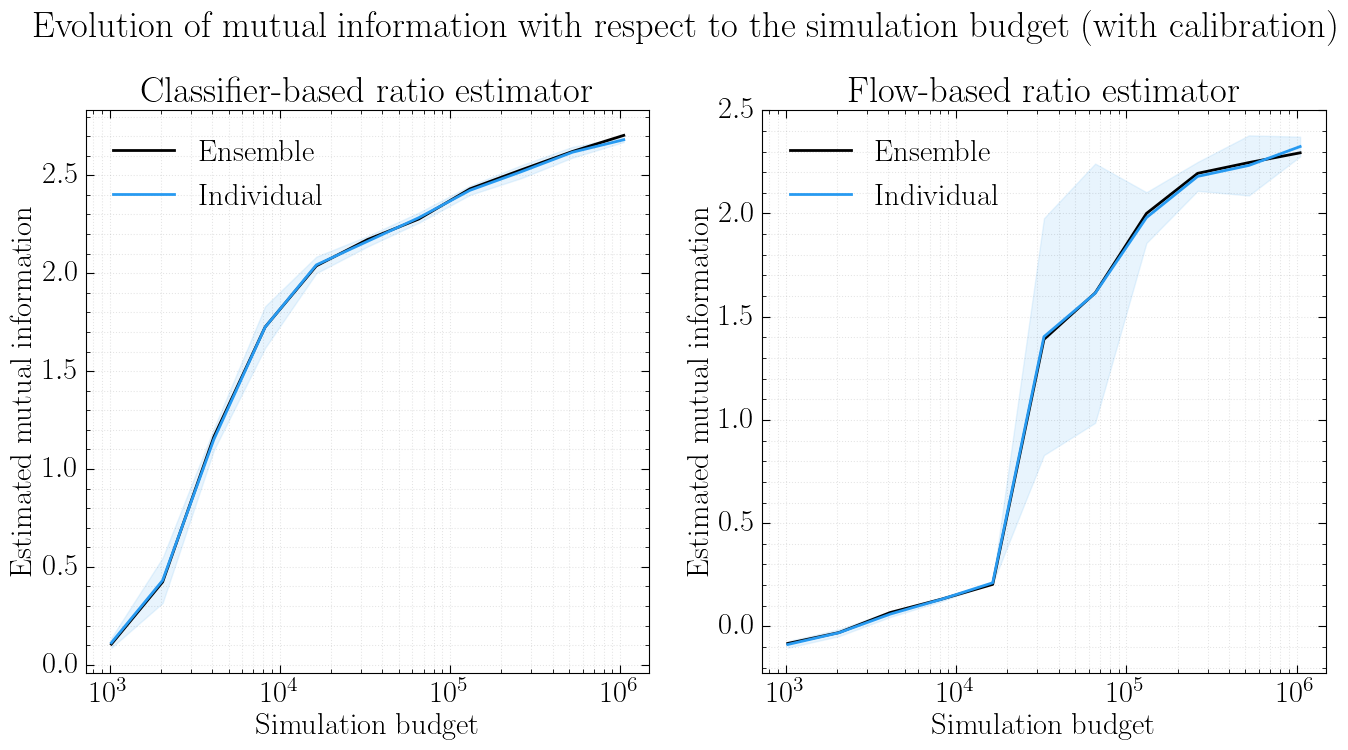

In [14]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
f.suptitle("Evolution of mutual information with respect to the simulation budget (with calibration)")

# Classifier
ax = axes[0]

## Ensemble
mis = []
for b in simulations:
    query = "output/{budget}/with-calibration/mlp-*/weights.th".format(budget=b)
    r = load_estimator(query)
    mis.append(estimate_mi(r))
ax.plot(simulations, mis, label="Ensemble")

## Individual model
mis = []
for b in simulations:
    query = "output/{budget}/with-calibration/mlp-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_mi(r))
    mis.append(estimates)
mis = np.asarray(mis)
m = np.mean(mis, axis=1)
s = np.std(mis, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Classifier-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Estimated mutual information")
ax.set_xlabel("Simulation budget")
ax.legend()
ylim = ax.get_ylim()
h.plot.make_square(ax)

# Flow
ax = axes[1]

## Ensemble
mis = []
for b in simulations:
    query = "output/{budget}/with-calibration/flow-*/weights.th".format(budget=b)
    r = load_estimator(query)
    mis.append(estimate_mi(r))
ax.plot(simulations, mis, label="Ensemble")

## Individual model
mis = []
for b in simulations:
    query = "output/{budget}/with-calibration/flow-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_mi(r))
    mis.append(estimates)
mis = np.asarray(mis)
m = np.mean(mis, axis=1)
s = np.std(mis, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Flow-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Estimated mutual information")
ax.set_xlabel("Simulation budget")
ax.legend()
# ax.set_ylim(ylim)
h.plot.make_square(ax)

plt.show()

### Without calibration

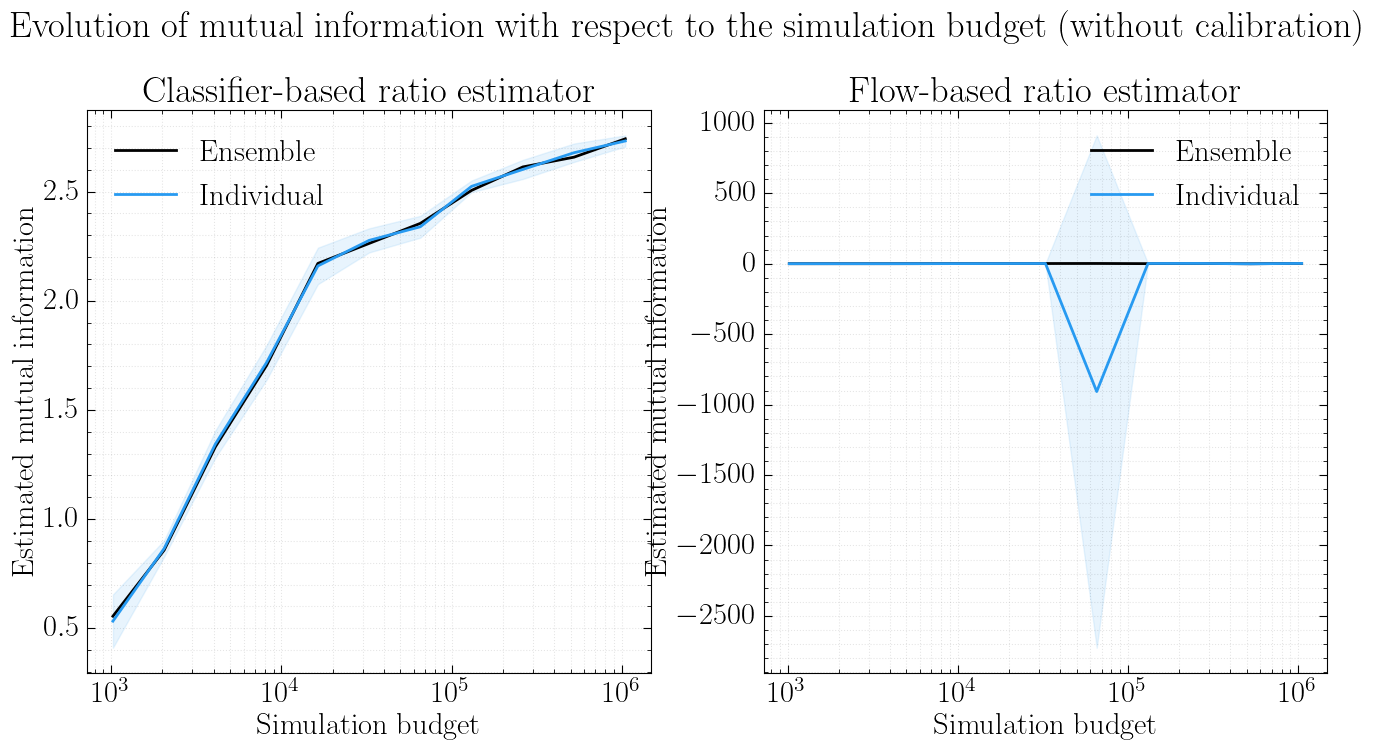

In [15]:
f, axes = plt.subplots(1, 2, figsize=(16, 8))
f.suptitle("Evolution of mutual information with respect to the simulation budget (without calibration)")

# Classifier
ax = axes[0]

## Ensemble
mis = []
for b in simulations:
    query = "output/{budget}/without-calibration/mlp-*/weights.th".format(budget=b)
    r = load_estimator(query)
    mis.append(estimate_mi(r))
ax.plot(simulations, mis, label="Ensemble")

## Individual model
mis = []
for b in simulations:
    query = "output/{budget}/without-calibration/mlp-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_mi(r))
    mis.append(estimates)
mis = np.asarray(mis)
m = np.mean(mis, axis=1)
s = np.std(mis, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Classifier-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Estimated mutual information")
ax.set_xlabel("Simulation budget")
ax.legend()
ylim = ax.get_ylim()
h.plot.make_square(ax)

# Flow
ax = axes[1]

## Ensemble
mis = []
for b in simulations:
    query = "output/{budget}/without-calibration/flow-*/weights.th".format(budget=b)
    r = load_estimator(query)
    mis.append(estimate_mi(r))
ax.plot(simulations, mis, label="Ensemble")

## Individual model
mis = []
for b in simulations:
    query = "output/{budget}/without-calibration/flow-*/weights.th".format(budget=b)
    estimates = []
    for p in glob.glob(query):
        r = load_estimator(p)
        estimates.append(estimate_mi(r))
    mis.append(estimates)
mis = np.asarray(mis)
m = np.mean(mis, axis=1)
s = np.std(mis, axis=1)
ax.plot(simulations, m, label="Individual", color="C1")
ax.fill_between(simulations, m - s, m + s, alpha=.1, color="C1")

## Plotting style
ax.set_title("Flow-based ratio estimator")
ax.set_xscale("log")
ax.set_ylabel("Estimated mutual information")
ax.set_xlabel("Simulation budget")
ax.legend()
# ax.set_ylim(ylim)
h.plot.make_square(ax)

plt.show()

## Losses

### With calibration

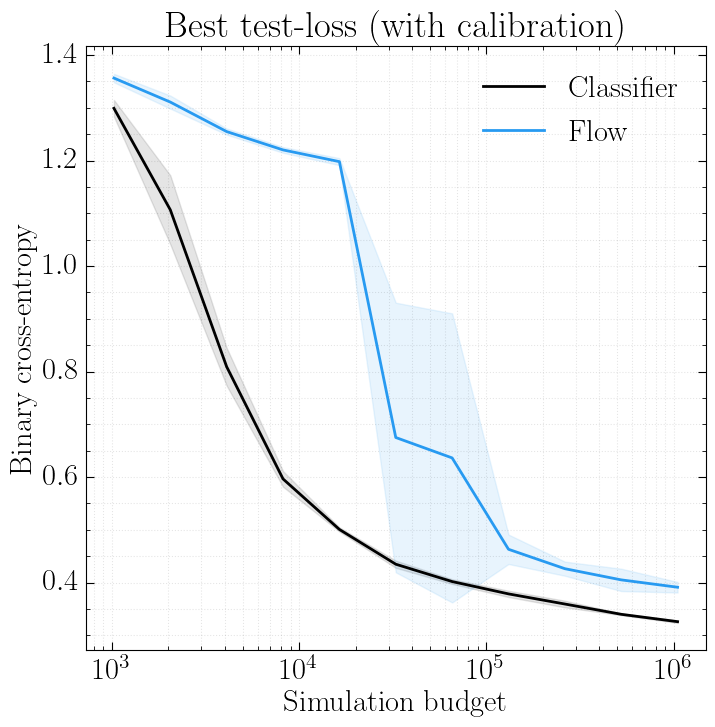

In [16]:
# Classifier
losses_classifier = []
for b in simulations:
    query = "output/{budget}/with-calibration/mlp-*/test-loss-functionals.npy".format(budget=b)
    losses = []
    for f in glob.glob(query):
        losses.append(np.min(np.load(f)))
    losses_classifier.append(losses)
    
losses = np.asarray(losses_classifier)
m = np.mean(losses, axis=1)
s = np.std(losses, axis=1)

plt.plot(simulations, m, label="Classifier")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C0")

# Flow
losses_classifier = []
for b in simulations:
    query = "output/{budget}/with-calibration/flow-*/test-loss-functionals.npy".format(budget=b)
    losses = []
    for f in glob.glob(query):
        losses.append(np.min(np.load(f)))
    losses_classifier.append(losses)
    
losses = np.asarray(losses_classifier)
m = np.mean(losses, axis=1)
s = np.std(losses, axis=1)

plt.plot(simulations, m, label="Flow")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")


plt.title("Best test-loss (with calibration)")
plt.ylabel("Binary cross-entropy")
plt.xlabel("Simulation budget")
plt.xscale("log")

plt.legend()
plt.show()

## Without calibration

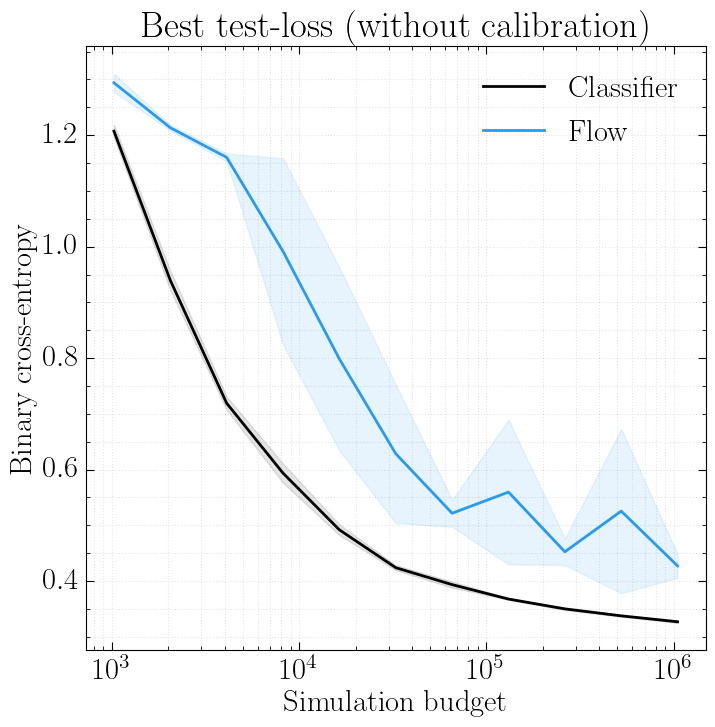

In [17]:
# Classifier
losses_classifier = []
for b in simulations:
    query = "output/{budget}/without-calibration/mlp-*/test-loss-functionals.npy".format(budget=b)
    losses = []
    for f in glob.glob(query):
        losses.append(np.min(np.load(f)))
    losses_classifier.append(losses)
    
losses = np.asarray(losses_classifier)
m = np.mean(losses, axis=1)
s = np.std(losses, axis=1)

plt.plot(simulations, m, label="Classifier")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C0")

# Flow
losses_classifier = []
for b in simulations:
    query = "output/{budget}/without-calibration/flow-*/test-loss-functionals.npy".format(budget=b)
    losses = []
    for f in glob.glob(query):
        losses.append(np.min(np.load(f)))
    losses_classifier.append(losses)
    
losses = np.asarray(losses_classifier)
m = np.mean(losses, axis=1)
s = np.std(losses, axis=1)

plt.plot(simulations, m, label="Flow")
plt.fill_between(simulations, m - s, m + s, alpha=0.1, color="C1")


plt.title("Best test-loss (without calibration)")
plt.ylabel("Binary cross-entropy")
plt.xlabel("Simulation budget")
plt.xscale("log")

plt.legend()
plt.show()

## Posteriors

In [18]:
inputs, outputs = simulate(n=1, directory=None)

cls = [0.68, 0.95, 0.997]
labels = [r"68\%", r"95\%", r"99.7\%"]

### Individual posteriors

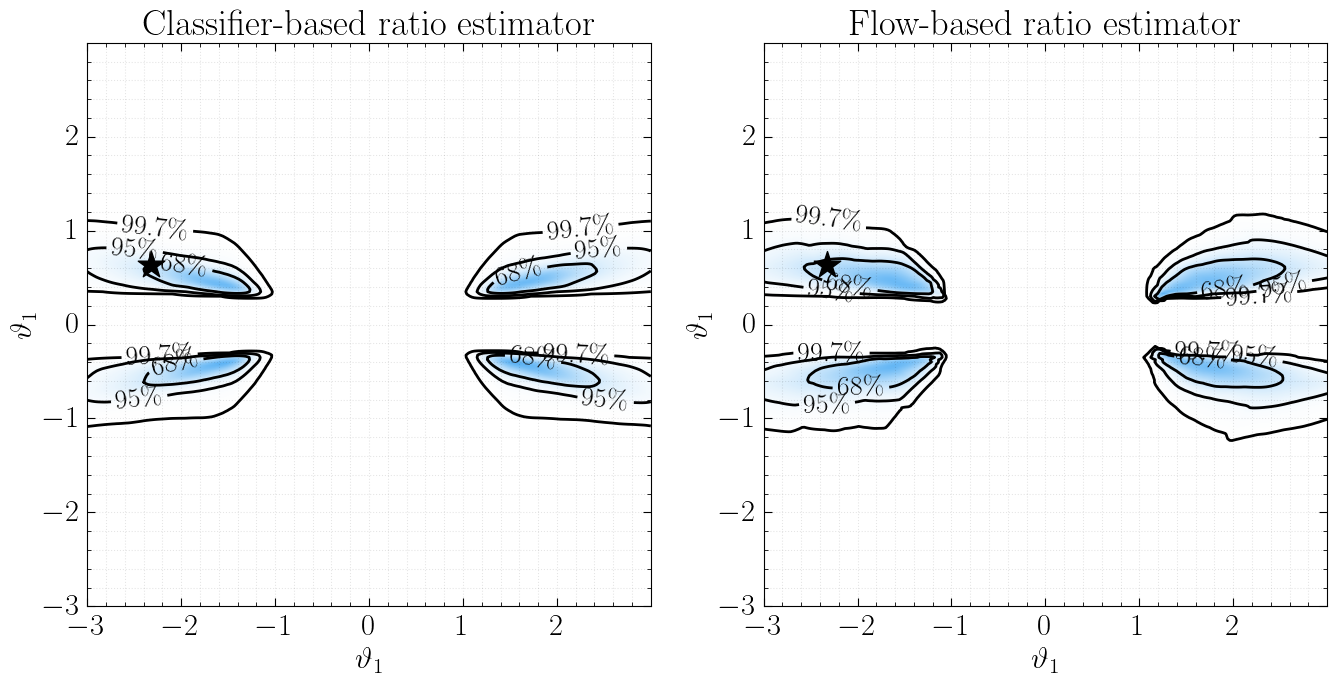

In [19]:
## With calibration

f, axes = plt.subplots(1, 2, figsize=(16, 8))
# Classifier
ax = axes[0]
r = load_estimator("output/{budget}/with-calibration/mlp-*/weights.th".format(budget=simulations[-1]))
ax.set_title("Classifier-based ratio estimator")
plot_posterior(ax, r, nominal=inputs, observable=outputs)
plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)

# Flow
ax = axes[1]
ax.set_title("Flow-based ratio estimator")
r = load_estimator("output/{budget}/with-calibration/flow-*/weights.th".format(budget=simulations[-1]))
plot_posterior(ax, r, nominal=inputs, observable=outputs)
plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)

plt.show()

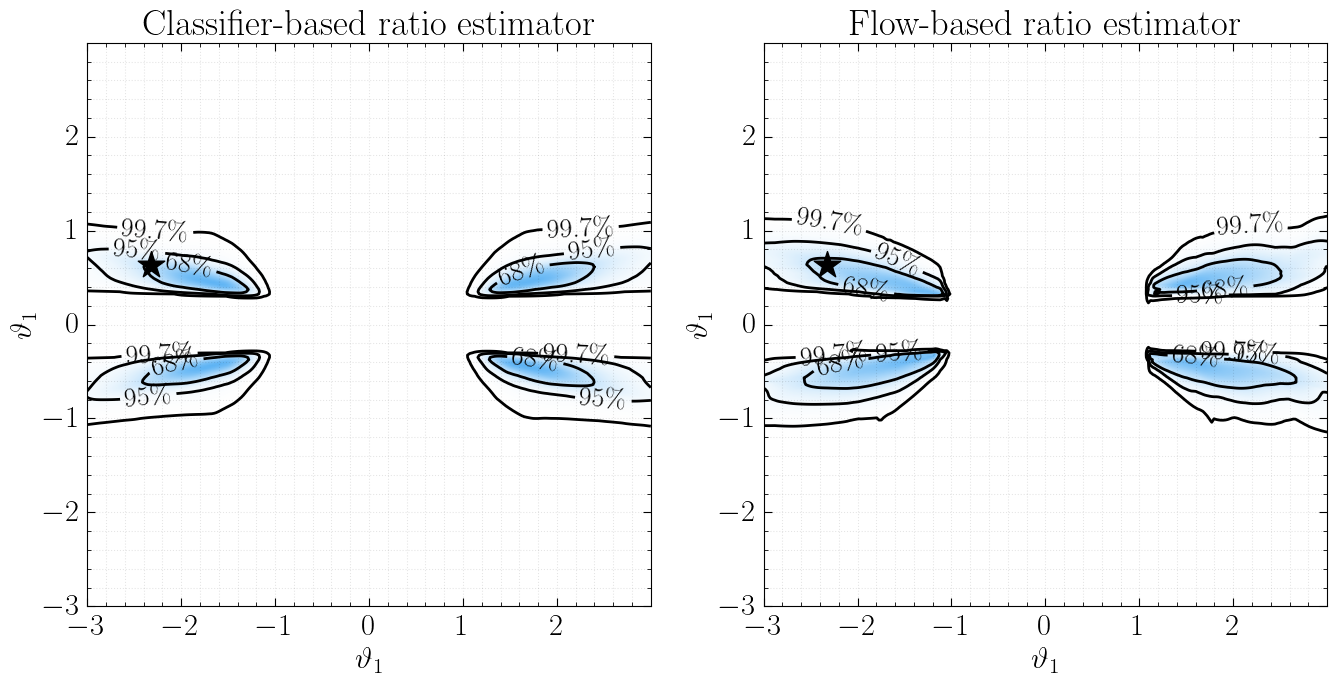

In [20]:
## Without calibration

f, axes = plt.subplots(1, 2, figsize=(16, 8))
# Classifier
ax = axes[0]
r = load_estimator("output/{budget}/without-calibration/mlp-*/weights.th".format(budget=simulations[-1]))
ax.set_title("Classifier-based ratio estimator")
plot_posterior(ax, r, nominal=inputs, observable=outputs)
plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)

# Flow
ax = axes[1]
ax.set_title("Flow-based ratio estimator")
r = load_estimator("output/{budget}/without-calibration/flow-*/weights.th".format(budget=simulations[-1]))
plot_posterior(ax, r, nominal=inputs, observable=outputs)
plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)

plt.show()

### How do the posteriors evolve with respect to the simulation budget?

#### Classifier-based ratio estimator

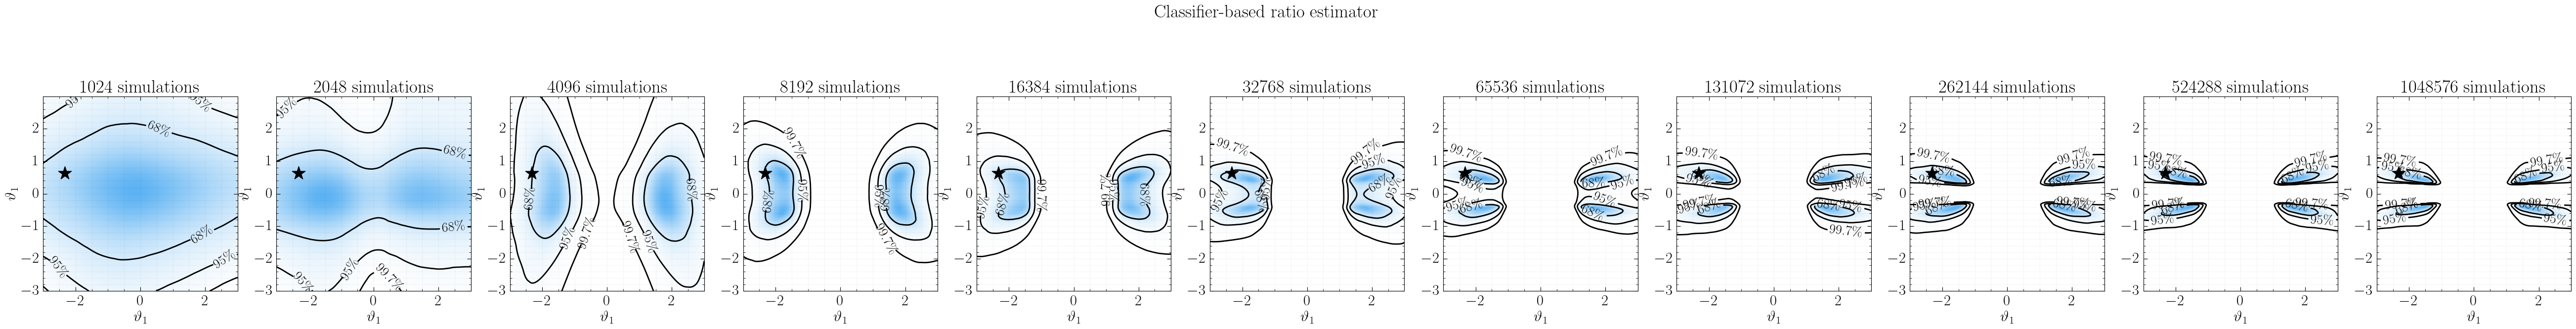

In [21]:
## With calibration

n = len(simulations)
f, axes = plt.subplots(1, n, figsize=(6 * n, 8))

f.suptitle("Classifier-based ratio estimator")

for b, ax in zip(simulations, axes):
    r = load_estimator("output/{budget}/with-calibration/mlp-*/weights.th".format(budget=b))  # Load ensemble
    ax.set_title(str(b) + " simulations")
    plot_posterior(ax, r, nominal=inputs, observable=outputs)
    plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)
    
plt.show()

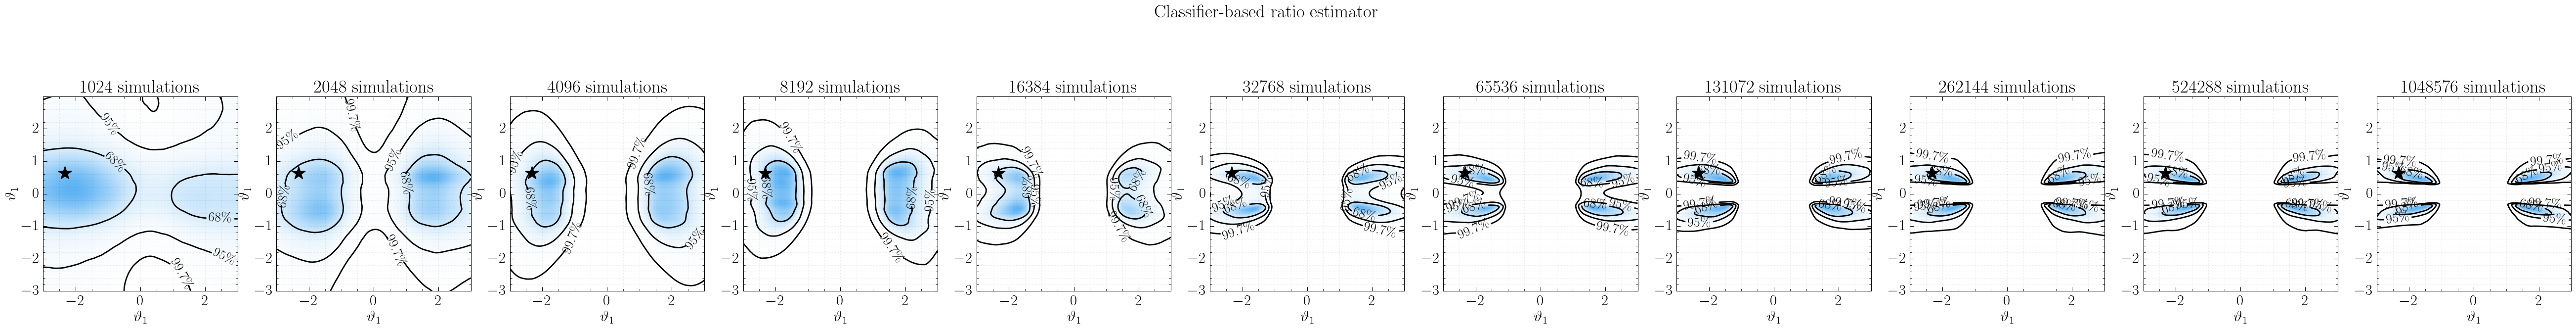

In [22]:
## Without calibration

n = len(simulations)
f, axes = plt.subplots(1, n, figsize=(6 * n, 8))

f.suptitle("Classifier-based ratio estimator")

for b, ax in zip(simulations, axes):
    r = load_estimator("output/{budget}/without-calibration/mlp-*/weights.th".format(budget=b))  # Load ensemble
    ax.set_title(str(b) + " simulations")
    plot_posterior(ax, r, nominal=inputs, observable=outputs)
    plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)
    
plt.show()

#### Flow-based ratio estimator

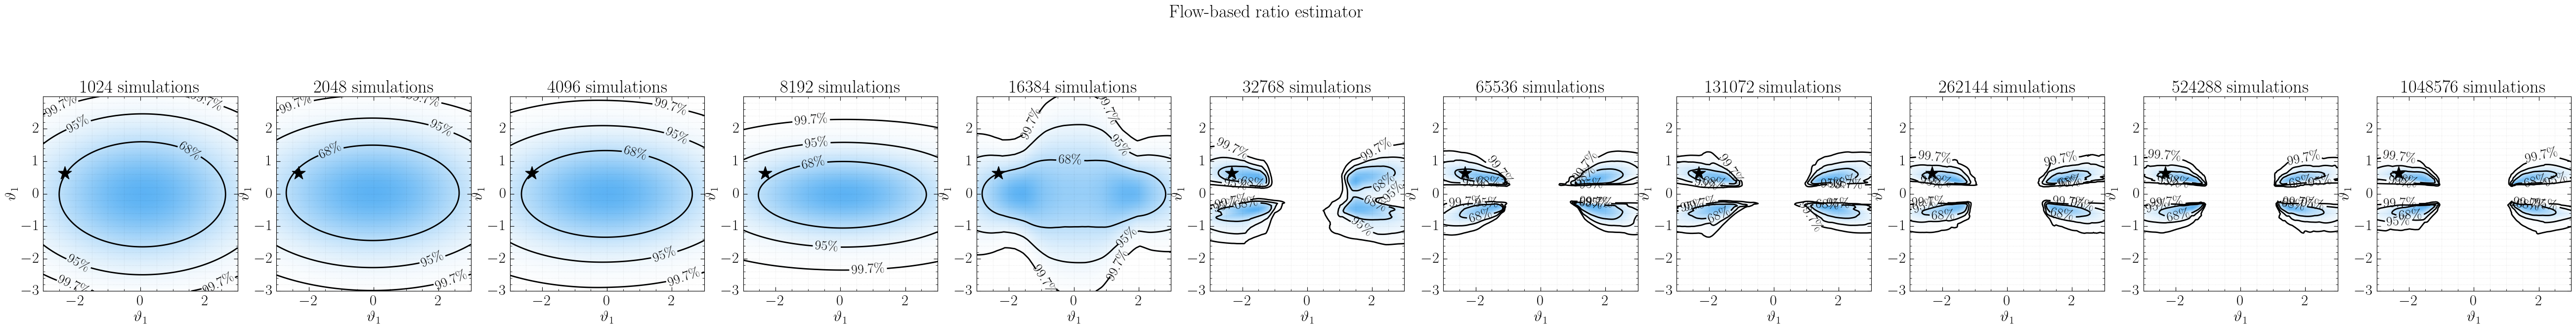

In [23]:
## With calibration

n = len(simulations)
f, axes = plt.subplots(1, n, figsize=(6 * n, 8))

f.suptitle("Flow-based ratio estimator")

for b, ax in zip(simulations, axes):
    r = load_estimator("output/{budget}/with-calibration/flow-*/weights.th".format(budget=b))  # Load ensemble
    ax.set_title(str(b) + " simulations")
    plot_posterior(ax, r, nominal=inputs, observable=outputs)
    plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)
    
plt.show()

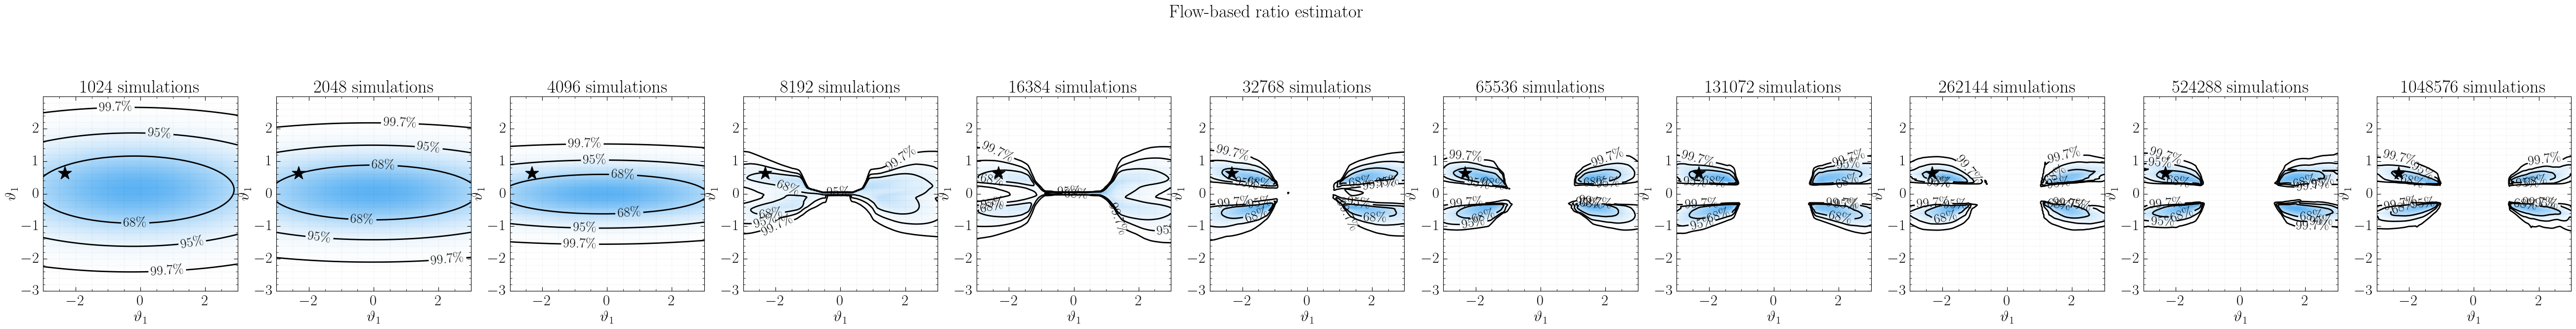

In [24]:
## Without calibration

n = len(simulations)
f, axes = plt.subplots(1, n, figsize=(6 * n, 8))

f.suptitle("Flow-based ratio estimator")

for b, ax in zip(simulations, axes):
    r = load_estimator("output/{budget}/without-calibration/flow-*/weights.th".format(budget=b))  # Load ensemble
    ax.set_title(str(b) + " simulations")
    plot_posterior(ax, r, nominal=inputs, observable=outputs)
    plot_contours(ax, r, observable=outputs, cls=cls, labels=labels)
    
plt.show()

## Summary plots for the paper

In [25]:
# TODO Implement